# Sensitivity Analysis

### Yonsei App.Stat
### Sunwoo Kim

### Paper Source: https://arxiv.org/pdf/1312.6034.pdf

기본적인 Gradient 기반 XAI 방법론인 Sensitivity analysis에 대해 알아보겠습니다.  
단순히 input까지의 gradient를 계산하는 구조입니다. $ \frac {\partial{y}} {\partial{x}}$  
모델과 데이터는 다음과 같습니다.  
1. Model : VGG16  
2. Data : CIFAR 10

## A. Image classification model Training

### A.1. Importing packages and data

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123)

**Transform data (Normalization)**

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

**Download data**

In [3]:
batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**CIFAR에는 총 10개의 class가 있으므로, 그것을 그대로 반영합니다.**

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**시각화에 사용할 보조 함수를 정의하고, 이미지를 확인합니다.**

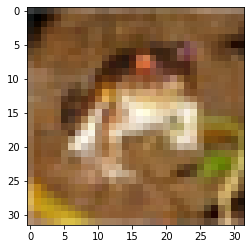

frog


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img, label = trainset[0] 
imshow(img)
print(classes[label])

개구리가 상당히 멋있네요. 이제 모델을 불러오겠습니다.

### A.2. Define model

Pytorch에 내장된 VGG architecture는 Image-Net 용으로 구현되어있고, FC layer에서 1000개의 output을 출력합니다. 따라서 CIFAR에 맞게 데이터를 변형하도록 하겠습니다.  
VGG 모델은https://github.com/deeplearningzerotoall/PyTorch 을 참고하였습니다.

In [6]:
class VGG(nn.Module): 
    def __init__(self, features, num_classes=10, init_weights=True) :
        super(VGG, self).__init__()
        self.features = features # Convolution layers의 구조는 그대로 활용
        self.classifier = torch.nn.Sequential( # 
            torch.nn.Linear(512*4*4, 4096), 
            torch.nn.ReLU(True), 
            torch.nn.Dropout(), 
            torch.nn.Linear(4096, num_classes)
        ) 
        if init_weights : 
            self._initialize_weights()
            
    def forward(self, x) : 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self): # 각종 가중치 초기화!
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, 
                                              mode='fan_out', 
                                              nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

In [7]:
vgg = models.vgg

cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [8]:
vgg16= VGG(vgg.make_layers(cfg),
           num_classes=10,
           init_weights=True).to(device)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

모델의 차원이 잘 구축되었는지 확인해보도록 하겠습니다.

In [9]:
a=torch.Tensor(1,3,32,32).to(device)
out = vgg16(a)
print(out)

tensor([[-5.0620e+35, -1.9894e+35, -2.7603e+35, -5.1475e+35, -8.8886e+35,
          1.0428e+36, -1.1631e+36,  8.6441e+35, -9.8975e+35, -6.9707e+35]],
       device='cuda:0', grad_fn=<AddmmBackward>)


깔끔하게 class가 호출됩니다. 이를 활용하여 모델을 학습시키도록 하겠습니다.

### A.3. Model Training

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr = 0.005,momentum=0.9)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [11]:
epochs = 60

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
        
print('Finished Training')

C:\Users\kswoo\Anaconda3\envs\sunwoo_env\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1,    30] loss: 2.300
[1,    60] loss: 2.289
[1,    90] loss: 2.189
[2,    30] loss: 1.933
[2,    60] loss: 1.807
[2,    90] loss: 1.745
[3,    30] loss: 1.635
[3,    60] loss: 1.598
[3,    90] loss: 1.522
[4,    30] loss: 1.452
[4,    60] loss: 1.403
[4,    90] loss: 1.376
[5,    30] loss: 1.304
[5,    60] loss: 1.301
[5,    90] loss: 1.243
[6,    30] loss: 1.205
[6,    60] loss: 1.175
[6,    90] loss: 1.159
[7,    30] loss: 1.107
[7,    60] loss: 1.108
[7,    90] loss: 1.076
[8,    30] loss: 1.000
[8,    60] loss: 1.050
[8,    90] loss: 0.978
[9,    30] loss: 0.959
[9,    60] loss: 0.946
[9,    90] loss: 0.944
[10,    30] loss: 0.876
[10,    60] loss: 0.902
[10,    90] loss: 0.874
[11,    30] loss: 0.819
[11,    60] loss: 0.827
[11,    90] loss: 0.827
[12,    30] loss: 0.780
[12,    60] loss: 0.792
[12,    90] loss: 0.763
[13,    30] loss: 0.714
[13,    60] loss: 0.731
[13,    90] loss: 0.753
[14,    30] loss: 0.693
[14,    60] loss: 0.699
[14,    90] loss: 0.676
[15,    30] loss: 0

In [13]:
torch.save(vgg16.state_dict(), 'VGG_cifar10.pt')

### A.4. 성능평가

Train 출력이 다소 길기때문에 모델의 가중치를 저장해 놓았습니다. 다시 불러오도록 해보겠습니다.

In [24]:
#vgg16 = torch.load("VGG_cifar10.pt")

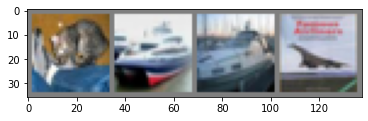

GroundTruth:    cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
vgg16 = vgg16.to(device)
outputs = vgg16(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


우선 몇가지 case에 대해서 적용한 결과는 4개 중 3개를 맞췄습니다.  
모든 test data에 대해서 적용해보도록 하겠습니다.

In [16]:
correct = 0
total = 0

from tqdm import tqdm

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.60it/s]

Accuracy of the network on the 10000 test images: 76 %


전체 모델의 성능이 썩 좋지만은 않은 것 같습니다.

## B. Sensitivity analysis

본격적으로 모델에 대한 explanation을 제시해보도록 하겠습니다.  
활용할 방법은 앞에서 언급했던 gradient를 계산하는 sensitivity analysis입니다.  
Gradient를 계산하여, 그것을 히트맵으로 놓고 input image에 씌우도록 하겠습니다.

### B.1. Gradient 계산

이미지에 대해서 gradient를 계산해주는 함수와 salinecy map을 생성하는 함수를 정의합니다.   
Saliency Map을 생성하는 코드는 아래 사이트를 참고하였습니다.  
https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

In [111]:
def get_gradient(model, img, target_index) : 
    model.eval()
    img = img.requires_grad_(True)
    outs = model(img.reshape(1,3,32,32).to(device))
    loss = outs[0, target_index]
    loss.backward()
    gradient = img.grad.abs().numpy() 
    final_grad = np.max(gradient, 0) # RGB 최댓값만 산출!
    return final_grad

def return_saliency_map(orig_image, gradient) : 
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(gradient, cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('Original Image and Saliency Map')
    plt.show()

Correspond label is 8


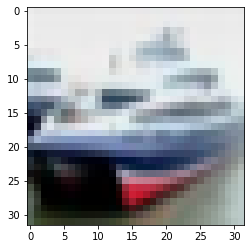

In [112]:
# 어떤 이미지인지 확인!
test_image, test_label = testset[1]
print("Correspond label is {0}".format(test_label))
imshow(test_image)

# 산출된 gradient를 할당!
final_grad = get_gradient(model = vgg16, 
            img = test_image, 
            target_index=test_label)

  우리는 gradient의 최댓값만 필요하기 때문에 RGB 중 최대의 gradient만 각 출력합니다.  
이를 활용해서 Saliency Map을 그려보겠습니다.

### B.2. Saliency Map

최종적으로 Map을 그려보도록 하겠습니다.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


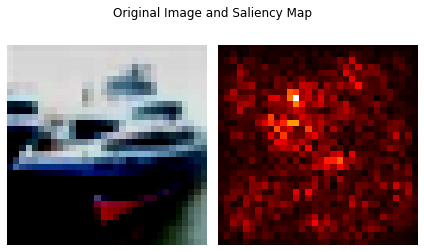

In [110]:
return_saliency_map(orig_image = test_image, 
                   gradient = final_grad)

1시방향과 5시 방향의 물과 하늘이 있는 부분은 상대적으로 gradient가 적게 산출되었고,  
중앙의 배가 포착된 부분은 gradient가 큰것을 확인할 수 있습니다.  
그러나 아주 명확하지는 않기때문에 다른 image도 확인해보도록 하겠습니다.

Correspond label is 6


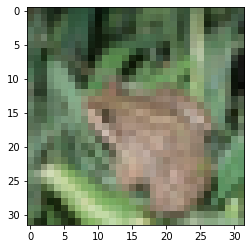

In [116]:
# 어떤 이미지인지 확인!
test_image, test_label = testset[4]
print("Correspond label is {0}".format(test_label))
imshow(test_image)

# 산출된 gradient를 할당!
final_grad = get_gradient(model = vgg16, 
            img = test_image, 
            target_index=test_label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


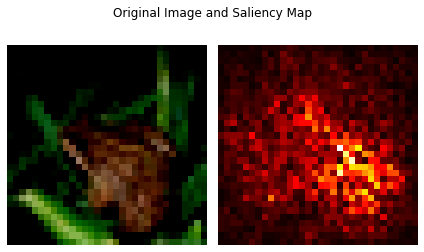

In [117]:
return_saliency_map(orig_image = test_image, 
                   gradient = final_grad)

개구리 예제를 확인해보니 확실히 개구리가 포착된 부분의 gradient가 크게 산출되는것을  
한눈에 확인할 수 있습니다.